In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp 
import scipy.constants  as cts
import magpylib as magpy

In [85]:
tfmot = magpy.Collection()
N = 4
angles = np.linspace(0, 360, N, endpoint=False)
l = 30
halbach = magpy.Collection()
for a in angles:
    cube= magpy.magnet.Cuboid(
    dimension=(8,6,80),
    polarization=(1.17,0,0),
    position=(30+l,0,0))
    
    cube.rotate_from_angax(a, 'z',anchor = 0)
    cube.rotate_from_angax(a, 'z')

    tfmot.add(cube)

magpy.show(tfmot, backend='plotly',)

In [86]:
def v_avg(m,T):
    return np.sqrt(8*cts.k*T/(np.pi*m))

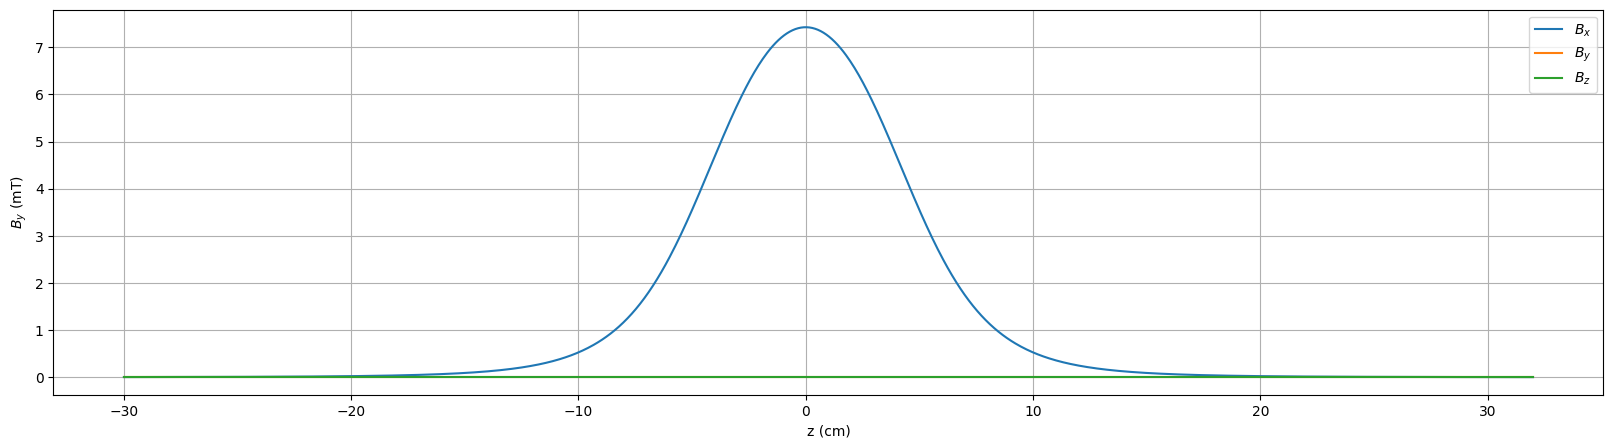

In [87]:
L = 16
z = np.linspace(-30,2*L,1000)
b_y = []
b_z = []
b_x = []
for i in z:
    b_x.append(tfmot.getB([0,0,i*10])[0])
    b_y.append(tfmot.getB([0,0,i*10])[1])
    b_z.append(tfmot.getB([0,0,i*10])[2])

fig,ax = plt.subplots(1,1,figsize=(20,5))    
plt.plot(z,np.array(b_x)*1e3)
plt.plot(z,np.array(b_y)*1e3)
plt.plot(z,np.array(b_z)*1e3)
#plt.yticks([-20,0,20,40])
#plt.xticks([-0.1,0,0.1,0.2,0.3,0.4])
plt.xlabel('z (cm)')

plt.ylabel('$B$ (mT)')
plt.legend(['$B_x$','$B_y$','$B_z$','Analytical'])  
plt.ylabel('$B_y$ (mT)')
plt.grid()

In [88]:
mass_lab = 173*cts.value('atomic mass constant') # YB-173 mass in kg
v_a = v_avg(mass_lab,216.85)
sd = np.sqrt(cts.k*216.85/mass_lab)
vel = np.random.normal(v_a,sd,1000000)
klab = 2*np.pi*25068.2222# Lab wavevector (without 2pi) in cm^{-1}   # Lifetime of 6P_{3/2} state (in seconds)
gammalab = (1.93*1e8)
v0 =max(vel)
Blab = -67*1e-3#(v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')
b_0L =  48*1e-3
# (v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')/2
# T # About 15 G/cm is a typical gradient for Rb
L = 16
x0 = 1/klab  # cm
t0 = 1/gammalab  # s
#100*(mass_lab*(v0**2))/(0.5*cts.hbar*(klab*100)*gammalab) +5
print(Blab, L,v0,b_0L)

-0.067 16 611.5412157667639 0.048


In [89]:
x0 = 1/klab  # cm
t0 = 1/gammalab  # s

mass = mass_lab*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = cts.value('Bohr magneton')*Blab*t0/cts.hbar
b_0 = cts.value('Bohr magneton')*b_0L*t0/cts.hbar 
l = L/x0 

print(x0, t0, mass, k, gamma, alpha,b_0)

6.348872362073421e-06 5.181347150259067e-09 2119.188266564296 1.0 1.0 -30.52874111941582 21.871336921372524


In [142]:
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 0,  	-0.2592,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035,	-0.2592,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)



#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 0,  	-0.2592,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035,	-0.2592,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)



#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)


s = 5
det = 5

# Define the laser beams:
laserBeams = pylcp.laserBeams([
    {'kvec':np.array([0, 1, 0]), 's': s,'pol_coord':'spherical', 'pol': 1, 'delta': (E_e_D2[2]-E_g_D2[0]) + det*gamma},
     {'kvec':np.array([0, -1, 0]), 's': s,'pol_coord':'spherical', 'pol':1, 'delta': (E_e_D2[2]-E_g_D2[0]) + det*gamma},
      {'kvec':np.array([1, 0, 0]), 's': s,'pol_coord':'spherical', 'pol': 1, 'delta': (E_e_D2[2]-E_g_D2[0]) + det*gamma},
     {'kvec':np.array([-1, 0, 0]), 's': s,'pol_coord':'spherical', 'pol':1, 'delta': (E_e_D2[2]-E_g_D2[0]) + det*gamma}],
    beam_type=pylcp.infinitePlaneWaveBeam) 

#linGrad =  pylcp.magField(lambda R: mag(R,b_0,alpha,l))
bf_mot = lambda R:tfmot.getB(R*10*x0)*cts.value('Bohr magneton')*t0/cts.hbar 
linGrad = pylcp.magField(lambda R: bf_mot(R))

In [143]:
(2*161e6*np.pi)/gammalab

5.24141365003064

In [144]:
rateeq = pylcp.rateeq(laserBeams, linGrad, hamiltonian_D2, include_mag_forces=True)

In [145]:
vc = x0/t0*1/(100)
Fc = cts.hbar*klab*gammalab
x = np.arange(-10, 10, 1)/x0
v = np.arange(-10, 10, 1)/vc

X, V = np.meshgrid(x, v)

Rvec = np.array([np.zeros(X.shape), X, np.zeros(X.shape)])
Vvec = np.array([np.zeros(X.shape), V, np.zeros(V.shape)])

rateeq.generate_force_profile(Rvec, Vvec, name='Fz', progress_bar=True)


Completed in 1.93 s.                                               


C:\Users\benfo\AppData\Local\Temp\ipykernel_35960\277109663.py:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Text(0.5, 1.0, 'Contour plot of position vs velocity and force')

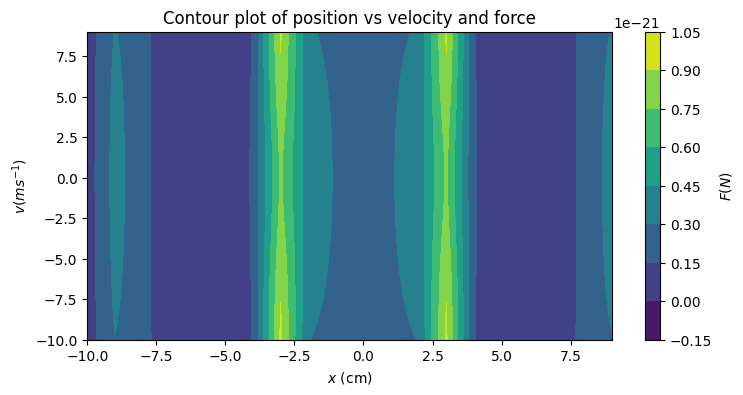

In [146]:

fig,ax = plt.subplots(1, 1, figsize=(8, 4)) 
cmap_reversed = plt.cm.get_cmap('viridis_r')
Fc = gammalab*cts.hbar*klab
im1 = ax.contourf(np.array(x)*x0, np.array(v)*vc,rateeq.profile['Fz'].F[0]*Fc)
fig.subplots_adjust(left=0.08, wspace=0.2)
cb1 = plt.colorbar(im1)
cb1.set_label('$F(N)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v (ms^{-1})$')
plt.title('Contour plot of position vs velocity and force')